In [1]:
import pymolpro as pmp
import math 
import numpy as np


def orbitalsize(orbital):
    tmp=orbital.second_moment_eigenvalues
    tmp=tmp.tolist()
    tmp=[float(i) for i in tmp]
    tmp.append(math.sqrt(sum([orbital.local_second_moments[i][i] for i in range(3)])))
    return np.array(tmp)

def chkorbid(o1,o2):
    if o1.startswith('-'):
        chko1=o1[1:]
    else:
        chko1=o1
    if o2.startswith('-'):
        chko2=o2[1:]
    else:
        chko2=o2
    if chko1==chko2:
        return True
    else: 
        return False

In [2]:
geo_list=['He','Ne','Ar','Kr']
p_list=[]

In [3]:
for i in geo_list:
    p=pmp.Project(i)
    p.write_input(f"""
    geometry={{{i}}}
    basis, cc-pv5z;
    rhf;
    locali, pipek;
    CCSD;
    put,xml
    """
                  )
    p.run(wait=True)
    p_list.append(p)
    print(i, "done")

He done
Ne done
Ar done
Kr done


In [18]:
pair_list=[]
test_dens_list=[]
train_arr_list=[]
arr_list=[]
test_arr_list=[]
test_corr_list=[]
for p in p_list:
    orbital_dt={}
    dens_dt={}
    if p.name=='Ar':
        for orbital in p.orbitals():
            orbital_dt.update({orbital.ID:
                orbitalsize(orbital)})
            orbital_dt.update({f'-{orbital.ID}':orbitalsize(orbital)})
            points=orbital.grid(4)
            values=orbital.evaluate(points,values=True)
            
            values=np.append(orbitalsize(orbital),values)
            dens_dt.update({f'{orbital.ID}':values})
            dens_dt.update({f'-{orbital.ID}':values})
        for pair in p.xpath("//pair"):
            tmp=pmp.element_to_dict(pair)
            oid1,oid2=tmp['orbital1'],tmp['orbital2']
            if chkorbid(oid1,oid2)==True:
                tmp_arr=np.array([orbital_dt[oid1]])
                tmp_arr=np.append(tmp_arr,dens_dt[oid1])
                test_arr_list.append(tmp_arr)
                test_corr_list.append(float(tmp['energy']))

    else:
        for orbital in p.orbitals():
            orbital_dt.update({orbital.ID:orbitalsize(orbital)})
            orbital_dt.update({f'-{orbital.ID}':orbitalsize(orbital)})
            points=orbital.grid(4)
            values=orbital.evaluate(points,values=True)
            
            values=np.append(orbitalsize(orbital),values)
            dens_dt.update({f'{orbital.ID}':values})
            dens_dt.update({f'-{orbital.ID}':values})
        for pair in p.xpath("//pair"):
            tmp=pmp.element_to_dict(pair)
            oid1,oid2=tmp['orbital1'],tmp['orbital2']
            if chkorbid(oid1,oid2)==True:
                tmp_arr=np.array([orbital_dt[oid1]])
                tmp_arr=np.append(tmp_arr,dens_dt[oid1])
                train_arr_list.append(tmp_arr)
                pair_list.append(float(tmp['energy']))
                    
labels=np.array(pair_list)
features=np.stack(train_arr_list)
test_arr=np.stack(test_arr_list)
test_labels=np.stack(test_corr_list)

In [19]:
import tensorflow as tf
tf.keras.backend.clear_session()


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - loss: 2.9644e-04 - mae: 0.0129 - mape: 85.7621  
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 8.3153e-05 - mae: 0.0073 - mape: 108.1241
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 2.1914e-05 - mae: 0.0041 - mape: 43.7707
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 3.0770e-05 - mae: 0.0049 - mape: 37.8378
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 1.3351e-05 - mae: 0.0027 - mape: 28.3674 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 2.2225e-05 - mae: 0.0042 - mape: 39.0314
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 3.6291e-05 - mae: 0.0053 - mape: 48.9565
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 1.7148e-05 - mae: 0.0034 - mape: 41.3261
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 2.6256e-05 - mae: 0.0044 - mape: 51.2623
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 4.5820e-05 - mae: 0.0054 -

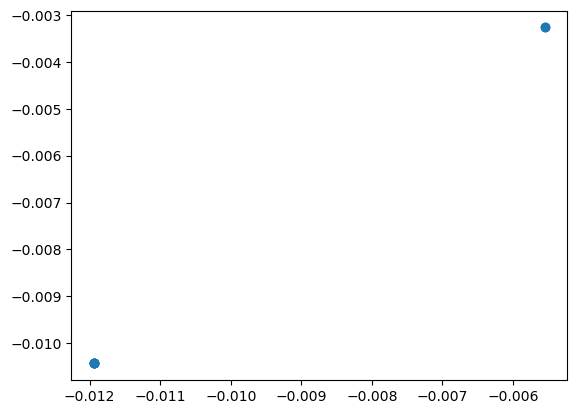

In [19]:
import keras
import tensorflow as tf

dataset=tf.data.Dataset.from_tensor_slices((features,labels))
dataset = dataset.shuffle(buffer_size=len(pair_list)//4).batch(batch_size=1)


model=keras.Sequential([
    keras.layers.Input(shape=(72,)),
    keras.layers.Dense(100, activation='softmax'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mse',
             metrics=['mae','mape'])
model.fit(dataset,epochs=50)

predictions=model.predict(test_arr)

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.scatter(test_labels,predictions)


In [12]:
print(predictions)

[[0.03130851]
 [0.03130851]
 [0.01388971]
 [0.01388971]
 [0.01388971]
 [0.01388971]
 [0.01388971]
 [0.01388971]]


In [ ]:
print(test_arr_list)

In [20]:

def buildmodel(act,loss):
    model=keras.Sequential([
        keras.layers.Input(shape=(72,)),
        keras.layers.Dense(64,activation=act),
        keras.layers.Dense(1,)
    ])
    model.compile(
        'Adam',
        loss=loss)
    return model

act_funcs=['relu','selu','tanh','sigmoid','gelu','softmax']
loss=['mse','mae','mape','huber']

result_dt=[]

q=0
for i in act_funcs:
    for j in loss:
        model=buildmodel(i,j)
        model.fit(dataset,epochs=25)
        tmp=np.array(model.predict(test_arr))
        result_dt.append({'params':{i,j},'predictions':tmp})


Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 0.2821
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.1480
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0125
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 8.2274e-04
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 4.4294e-04
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 1.5282e-04
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 5.2639e-05
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 5.3555e-05
Epoch 9/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 3.6874e-05
Epoch 10/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 5.0691e-05
Epoch 11/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 4.0922e-05
Epoch 12/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 9.0110e-05
Epoch 13/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 2.9561e-04
Epoch 14/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 6.1635e-04
Epoch 15/25
1

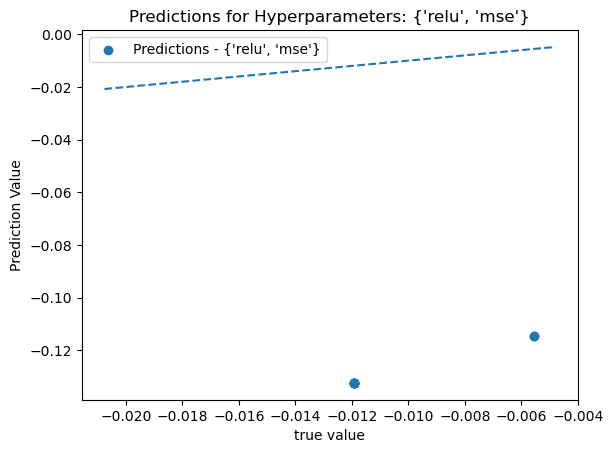

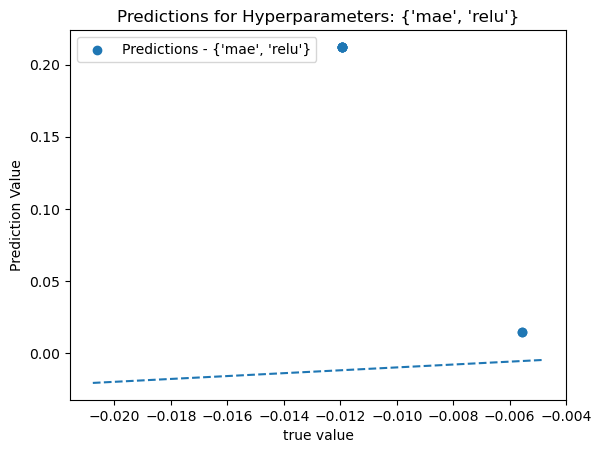

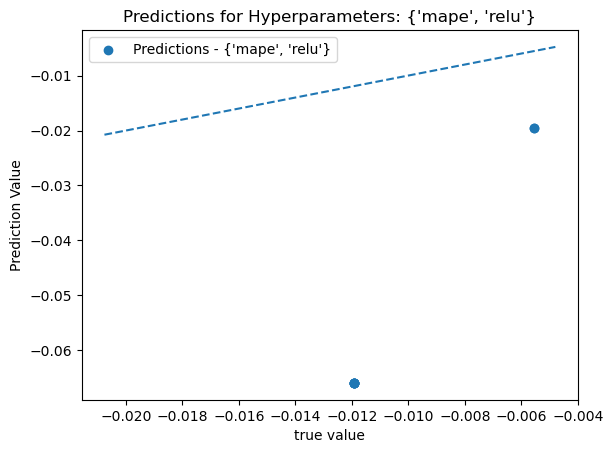

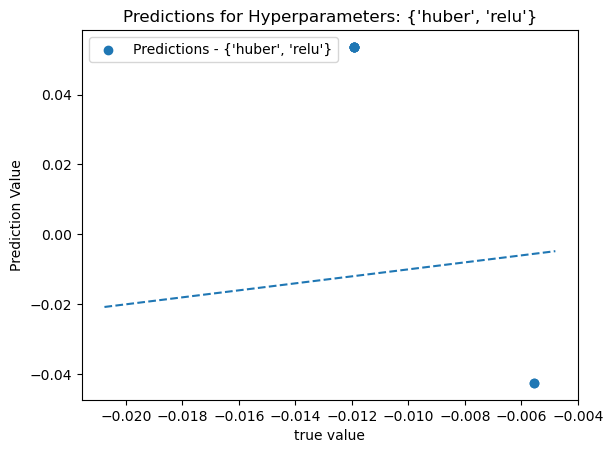

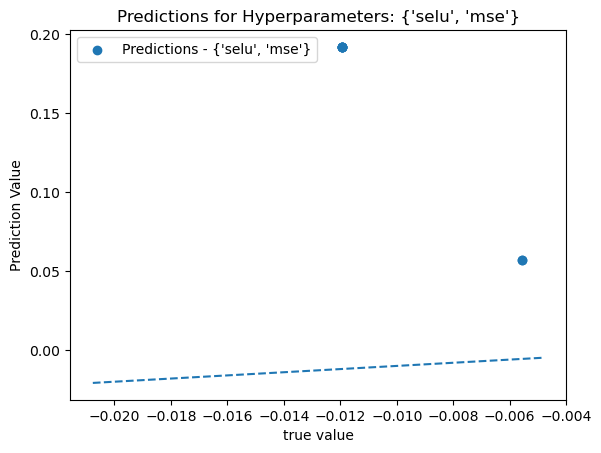

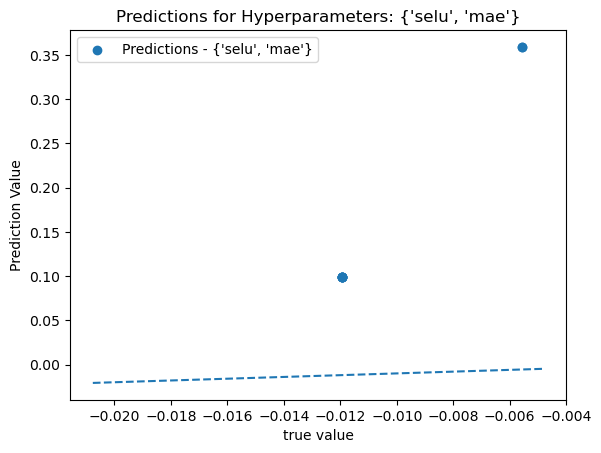

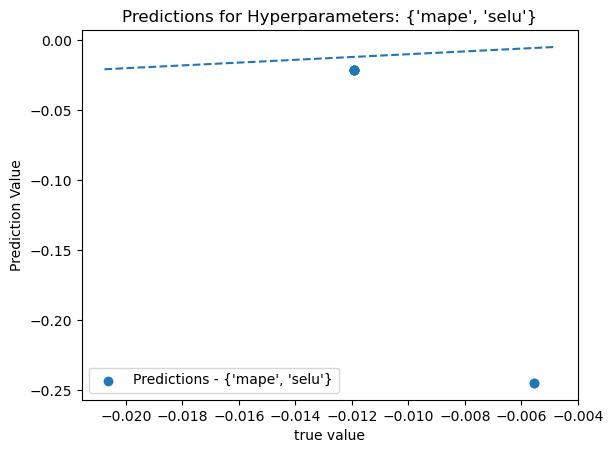

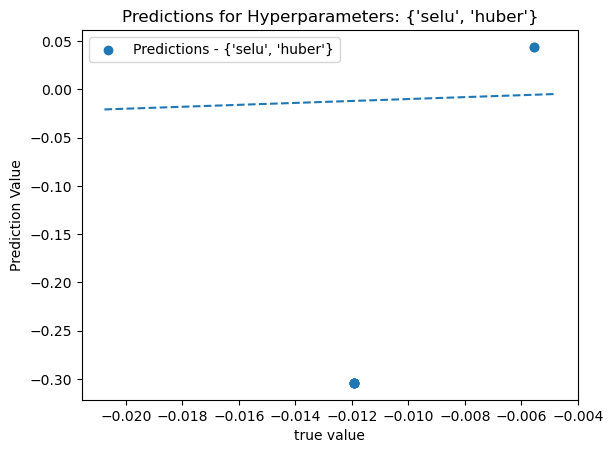

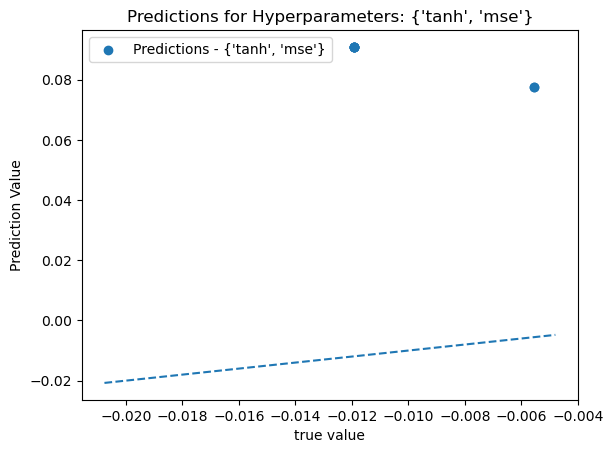

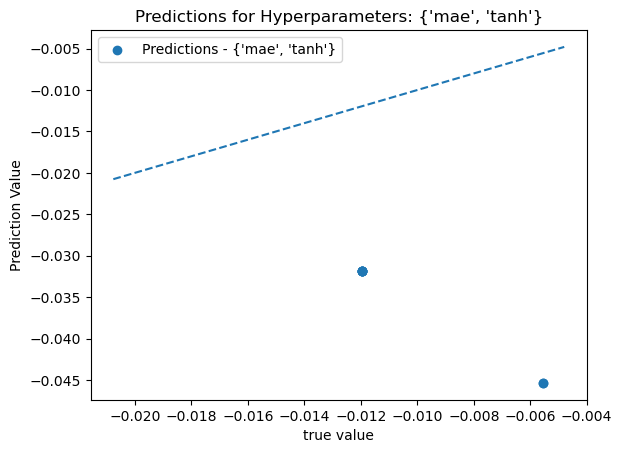

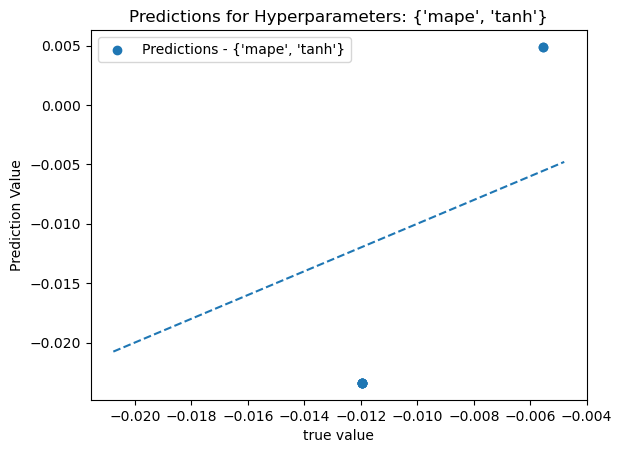

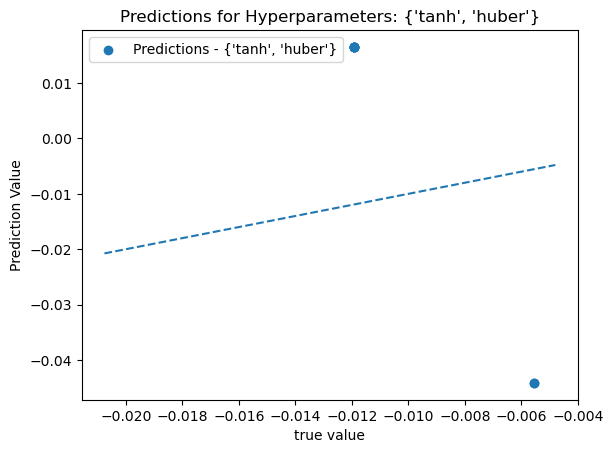

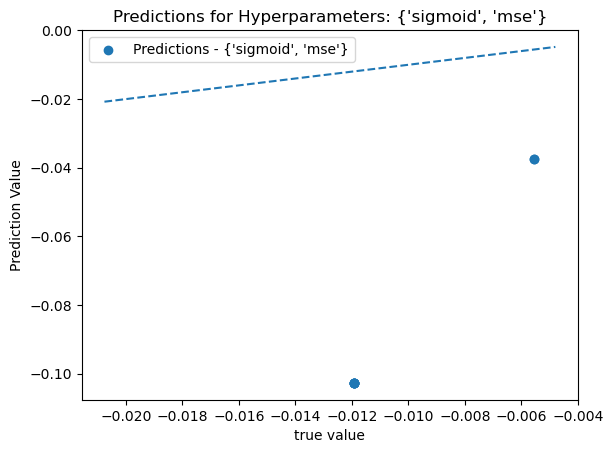

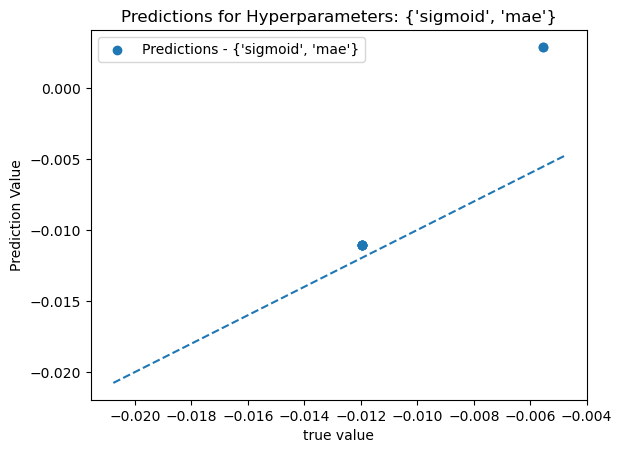

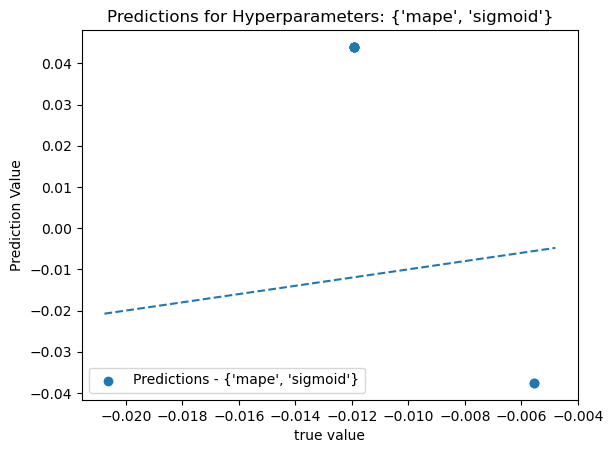

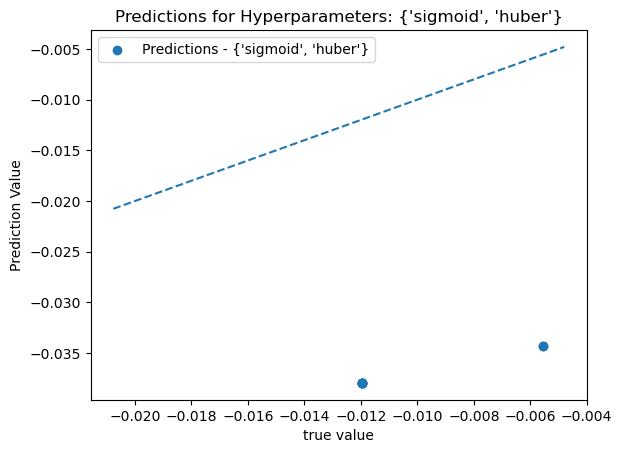

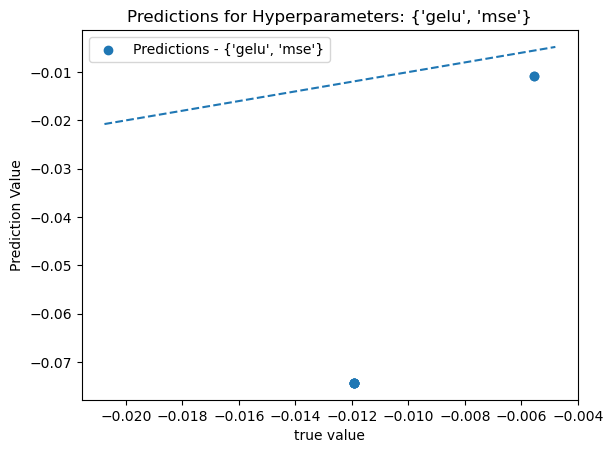

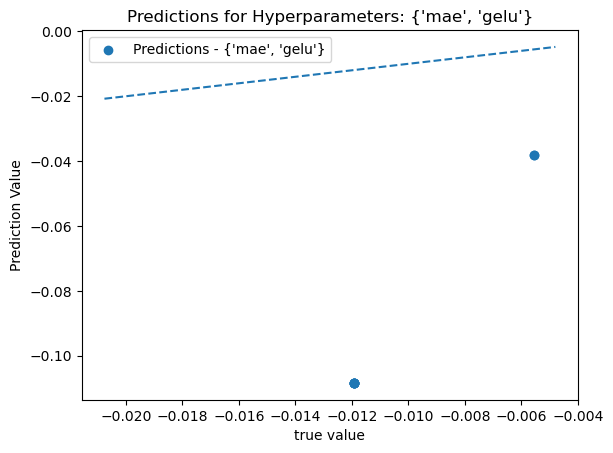

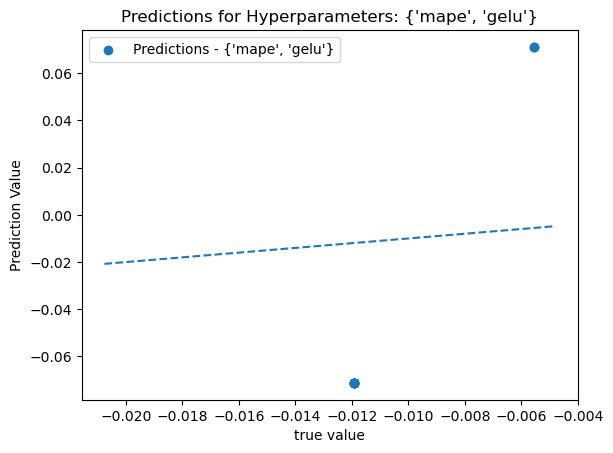

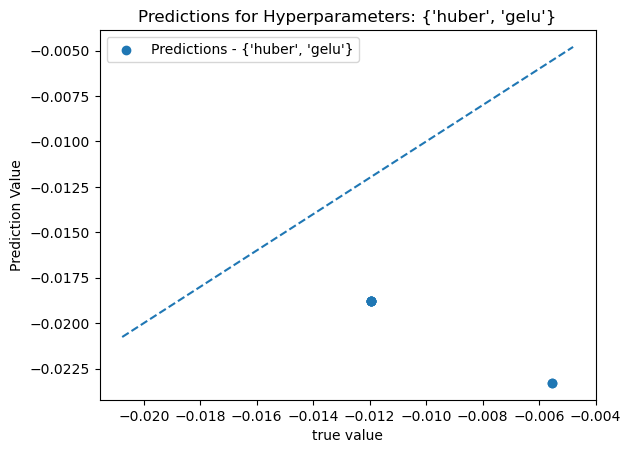

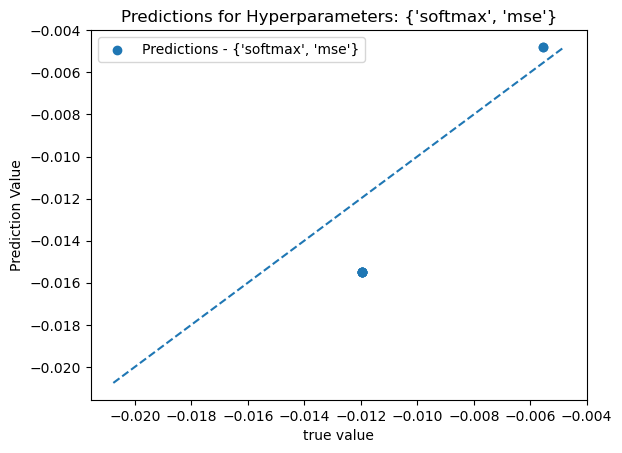

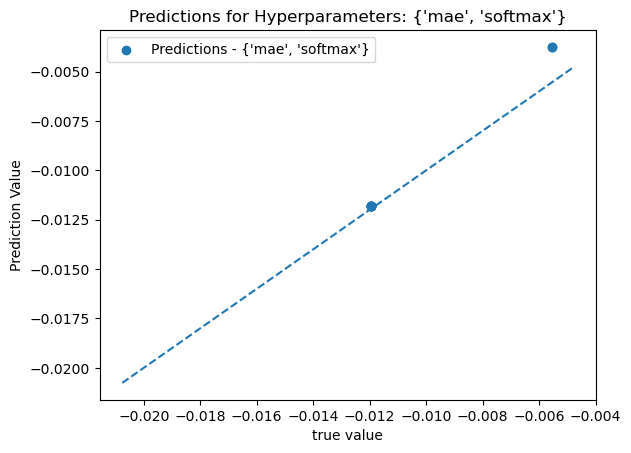

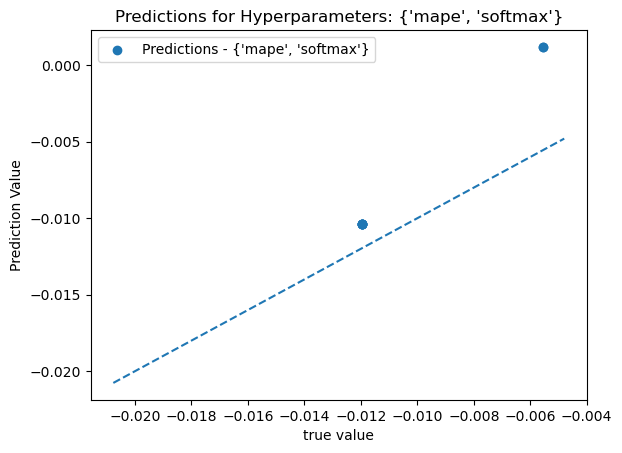

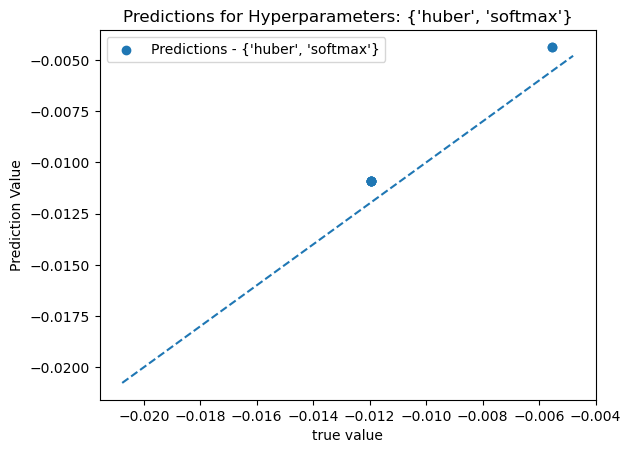

In [21]:
for i,results in enumerate(result_dt):
    plt.figure(i)
    plt.scatter(test_labels, results['predictions'], label=f"Predictions - {results['params']}")
    plt.title(f"Predictions for Hyperparameters: {results['params']}")
    plt.plot((min(labels),max(labels)),(min(labels),max(labels)),linestyle='--')
    plt.xlabel("true value")
    plt.ylabel("Prediction Value")
    plt.legend()
    plt.show()
    

In [39]:
from sklearn.metrics import mean_squared_error
def buildmodel(units):
    model=keras.Sequential([
        keras.layers.Input(shape=(72,)),
        keras.layers.Dense(units,activation='softmax'),
        keras.layers.Dense(1,)
    ])
    model.compile(
        'Adam',
        loss='huber')
    return model

mse_list=[]
for i in range(36,720,36):
    model=buildmodel(i)
    model.fit(dataset,epochs=30)
    tmp=np.array(model.predict(test_arr))
    result_dt.append({'params':{i,j},'predictions':tmp})
    mse_list.append({'units':i,'mse':mean_squared_error(tmp,test_labels)})
    
    

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - loss: 5.3549e-04 
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 5.9821e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 1.1657e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 1.7896e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 4.2948e-06
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 1.9252e-06
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 1.8269e-06
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 6.0607e-07
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 5.5219e-07
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 5.8140e-07
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 1.3669e-07
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 2.0549e-07
Epoch 13/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 9.5599e-07
Epoch 14/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 3.4994e-07


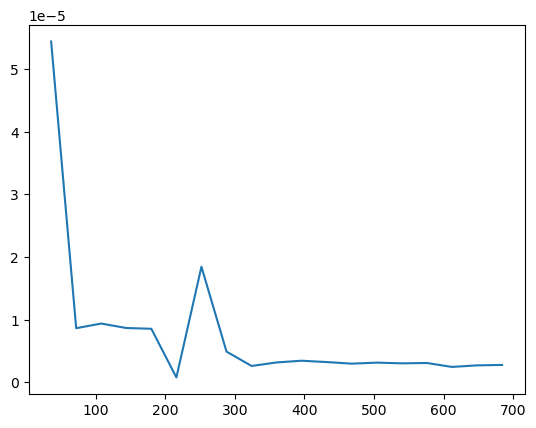

In [40]:
units=[entry['units'] for entry in mse_list]
mse=[entry['mse'] for entry in mse_list]
plt.plot(units,mse)
plt.show()

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - loss: 9.3916e-05 
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 1.1936e-05
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 6.9938e-06
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 4.4942e-06
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 9.6135e-07
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 4.2065e-07
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 3.7415e-07
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 2.2570e-07
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 6.3435e-07
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 1.1890e-07
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 4.0486e-07
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 3.0470e-07
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 1.2128e-06
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 3.0962e-07


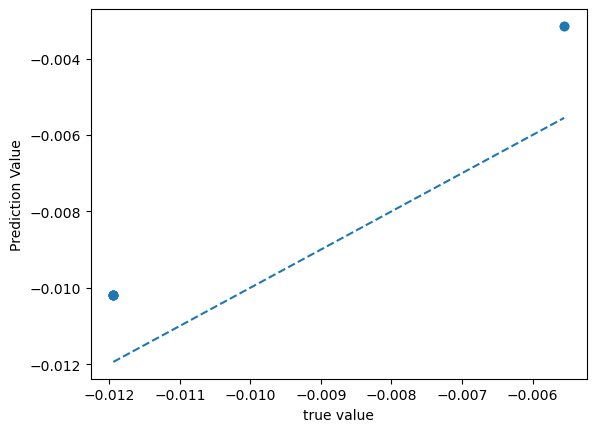

In [42]:
model=keras.Sequential([
    keras.layers.Input(shape=(72,)),
    keras.layers.Dense(216,activation='softmax'),
    keras.layers.Dense(1,)
])
model.compile(
'Adam',
loss='huber')
model.fit(dataset,epochs=50)
tmp=model.predict(test_arr)
plt.scatter(test_labels,tmp)
plt.plot((min(test_labels),max(test_labels)),(min(test_labels),max(test_labels)),linestyle='--')
plt.xlabel("true value")
plt.ylabel("Prediction Value")
plt.show()

In [45]:
def buildmodel(depth,acti):
    model=keras.Sequential()
    model.add(keras.layers.Input(shape=(72,)))
    model.add(keras.layers.Dense(216,activation='softmax'))
    for i in range(depth):
        model.add(keras.layers.Dense(99,activation=acti))
    model.add(keras.layers.Dense(1,))
    model.compile(
        'Adam',
        loss='huber')
    return model
actis=['tanh','sigmoid','relu','gelu']
depth_list=[i for i in range(10)]

tanhr_list=[]
sigmoidr_list=[]
relur_list=[]
gelur_list=[]

for i in depth_list:
    for j in actis:
        model=buildmodel(i,j)
        model.fit(dataset,epochs=30)
        tmp=np.array(model.predict(test_arr))
        if j=='tanh':
            tanhr_list.append({'depth':i,'mse':mean_squared_error(test_labels,tmp)})
        elif j=='relu':
           relur_list.append({'depth':i,'mse':mean_squared_error(test_labels,tmp)})
        elif j=='sigmoid':
            sigmoidr_list.append({'depth':i,'mse':mean_squared_error(test_labels,tmp)})
        elif j=='gelu':
            gelur_list.append({'depth':i,'mse':mean_squared_error(test_labels,tmp)})
        

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - loss: 8.1709e-05 
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 1.0623e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 1.1259e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 7.1316e-06
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.8873e-06
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 9.8681e-07
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 5.6589e-07
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 4.7606e-07
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 2.9092e-07
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 2.1455e-07
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 3.4401e-07
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1.5424e-07
Epoch 13/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 4.4304e-07
Epoch 14/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 1.7028e-07


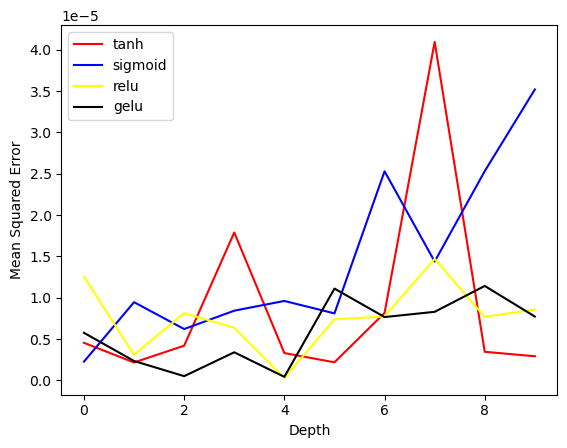

In [47]:
tanh_list=[i['mse'] for i in tanhr_list]
sigmoid_list=[i['mse'] for i in sigmoidr_list]
relu_list=[i['mse'] for i in relur_list]
gelu_list=[i['mse'] for i in gelur_list]


plt.plot(depth_list,tanh_list,c='red',label='tanh')
plt.plot(depth_list,sigmoid_list,c='blue',label='sigmoid')
plt.plot(depth_list,relu_list,c='yellow',label='relu')
plt.plot(depth_list,gelu_list,c='black',label='gelu')
plt.ylabel('Mean Squared Error')
plt.xlabel('Depth')
plt.legend()
plt.savefig('Depth_softmax.png')
plt.show()





Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - loss: 4.3422e-05 - mae: 0.0077 - mape: 82.5482
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8710e-05 - mae: 0.0073 - mape: 61.4685
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 1.5294e-05 - mae: 0.0044 - mape: 51.3751
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 4.4771e-05 - mae: 0.0080 - mape: 65.2809
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 3.0106e-05 - mae: 0.0067 - mape: 66.8236
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 4.1097e-05 - mae: 0.0076 - mape: 80.4583
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 2.5440e-05 - mae: 0.0050 - mape: 42.1543 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1.4221e-05 - mae: 0.0040 - mape: 37.2049
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 5.5453e-06 - mae: 0.0029 - mape: 31.9956
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 4.7574e-06 - mae: 0.0028 - mape

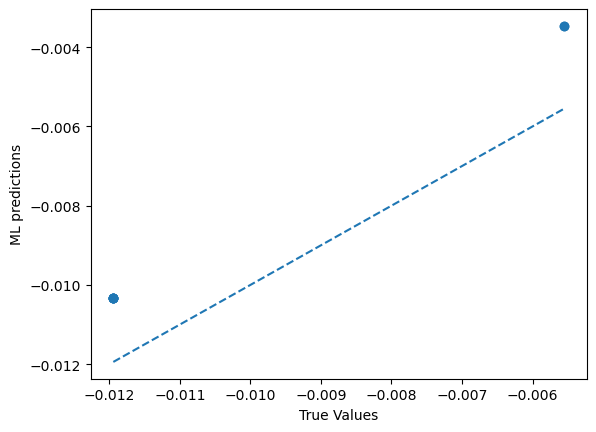

In [50]:

model=keras.Sequential([
    keras.layers.Input(shape=(72,)),
    keras.layers.Dense(216, activation='softmax'),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='huber',
             metrics=['mae','mape'])
model.fit(dataset,epochs=50)

predictions=model.predict(test_arr)
plt.scatter(test_labels,predictions)
plt.plot((min(test_labels),max(test_labels)),(min(test_labels),max(test_labels)), linestyle='--')
plt.xlabel('True Values')
plt.ylabel('ML predictions')
plt.show()